In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

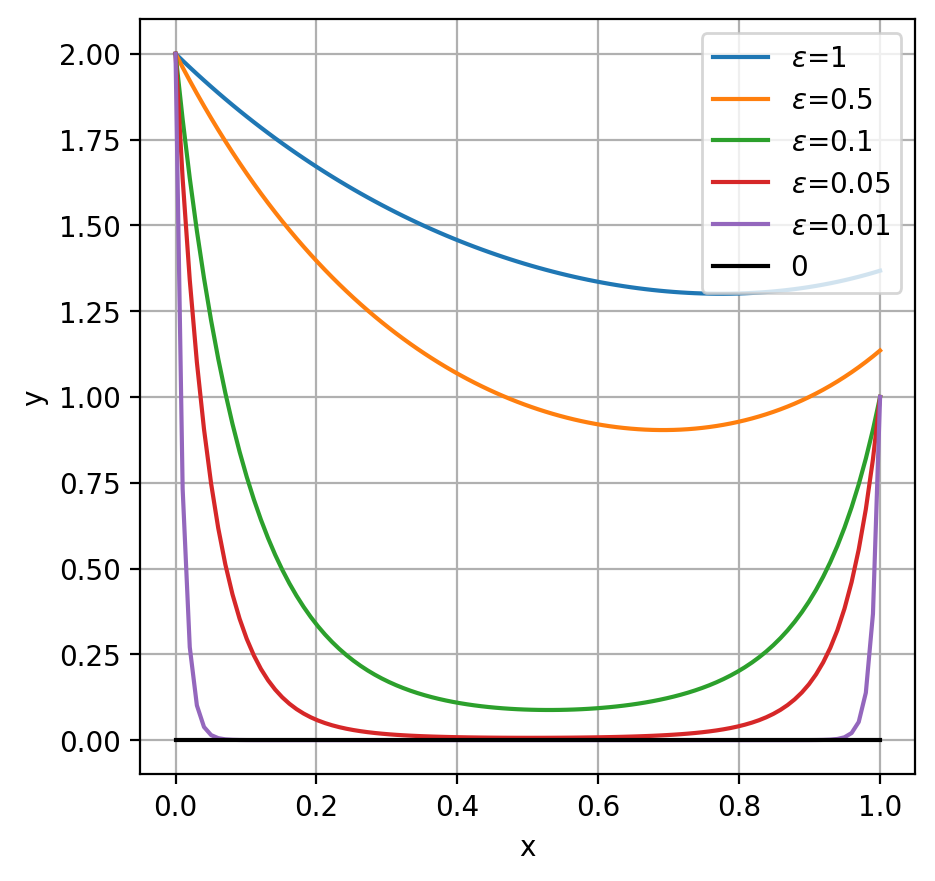

In [4]:
x = np.linspace(0,1,100)
x = np.array([x]).T

def solution(x,e):
    return np.exp(-x/e) + np.exp((x**2-x)/e)

plt.figure(figsize=(5,5),dpi=200)
plt.plot(x,solution(x,1),label='$\epsilon$=1')
plt.plot(x,solution(x,0.5),label='$\epsilon$=0.5')
plt.plot(x,solution(x,0.1),label='$\epsilon$=0.1')
plt.plot(x,solution(x,0.05),label='$\epsilon$=0.05')
plt.plot(x,solution(x,0.01),label='$\epsilon$=0.01')
plt.plot(x,np.zeros(100),label='0',c='k')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

e = 0.01
y = solution(x,e)

x_b = np.array([[0],[1]],dtype='float')
y_b = np.array([[2],[1+np.exp(-1/e)]],dtype='float')
x_f = lhs(1, 10000)
x_b = tf.constant(x_b,dtype=tf.float32)
x_f = tf.constant(x_f,dtype=tf.float32)
y_b = tf.constant(y_b,dtype=tf.float32)
x = tf.constant(x,dtype=tf.float32)
y = tf.constant(y,dtype=tf.float32)

In [7]:
def new_PINN(model,index_1,index_2):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    count = 0
    idx = []
    part = []
    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n
    part = tf.constant(part)
    pinn_params_last_index = idx[-1].numpy()[0]
    
    index_1_shapes = tf.shape_n(index_1.trainable_variables)
    index_1_n_tensors = len(index_1_shapes)
    index_1_count = 0
    index_1_idx = []
    index_1_part = []
    for i, shape in enumerate(index_1_shapes):
        n = np.product(shape)
        index_1_idx.append(tf.reshape(tf.range(index_1_count, index_1_count+n, dtype=tf.int32), shape))
        index_1_part.extend([i]*n)
        index_1_count += n
    index_1_part = tf.constant(index_1_part)
    
    index_2_shapes = tf.shape_n(index_2.trainable_variables)
    index_2_n_tensors = len(index_2_shapes)
    index_2_count = 0
    index_2_idx = []
    index_2_part = []
    for i, shape in enumerate(index_2_shapes):
        n = np.product(shape)
        index_2_idx.append(tf.reshape(tf.range(index_2_count, index_2_count+n, dtype=tf.int32), shape))
        index_2_part.extend([i]*n)
        index_2_count += n
    index_2_part = tf.constant(index_2_part)
    
    index_1_params_last_index = index_1_idx[-1].numpy()[0]
    index_2_params_last_index = index_2_idx[-1].numpy()[0]

    @tf.function
    def assign_new_model_parameters(pinn_params_1d):
        params = tf.dynamic_partition(pinn_params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def assign_new_index_1_parameters(index_1_params_1d):
        params = tf.dynamic_partition(index_1_params_1d, index_1_part, index_1_n_tensors)
        for i, (shape, param) in enumerate(zip(index_1_shapes, params)):
            index_1.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def assign_new_index_2_parameters(index_2_params_1d):
        params = tf.dynamic_partition(index_2_params_1d, index_2_part, index_2_n_tensors)
        for i, (shape, param) in enumerate(zip(index_2_shapes, params)):
            index_2.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def f(params_1d):
        c2 = tf.reshape(params_1d[-2],(1,))
        c1 = tf.reshape(params_1d[-1],(1,))
        pinn_params_1d = params_1d[:pinn_params_last_index+1]
        index_1_params_1d = params_1d[pinn_params_last_index+1:pinn_params_last_index+index_1_params_last_index+2]
        index_2_params_1d = params_1d[pinn_params_last_index+index_1_params_last_index+2:pinn_params_last_index+index_1_params_last_index+index_2_params_last_index+3]
        with tf.GradientTape() as tape:
            tape.watch([model.trainable_variables,index_1.trainable_variables,index_2.trainable_variables,c2,c1])
            assign_new_model_parameters(pinn_params_1d)
            assign_new_index_1_parameters(index_1_params_1d)
            assign_new_index_2_parameters(index_2_params_1d)
            loss_value = Loss_new_PINN(model,index_1,index_2,c1,c2)
        grads = tape.gradient(loss_value, [model.trainable_variables,index_1.trainable_variables,index_2.trainable_variables,c2,c1])
        pinn_grads = tf.dynamic_stitch(idx, grads[0])
        index_1_grads = tf.dynamic_stitch(index_1_idx, grads[1])
        index_2_grads = tf.dynamic_stitch(index_2_idx, grads[2])
        newgrads = tf.concat([pinn_grads,index_1_grads,index_2_grads,grads[3],grads[4]],0)
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])
        return loss_value, newgrads
    
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    
    f.index_1_idx = index_1_idx
    f.index_1_part = index_1_part
    f.index_1_shapes = index_1_shapes
    f.assign_new_index_1_parameters = assign_new_index_1_parameters
    
    f.index_2_idx = index_2_idx
    f.index_2_part = index_2_part
    f.index_2_shapes = index_2_shapes
    f.assign_new_index_2_parameters = assign_new_index_2_parameters
    
    f.history = []

    return f

def Loss_new_PINN(model,index_1,index_2,c1,c2):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_f)
        y_pred_f = model.call(x_f)
        y_pred_f += c1*tf.exp(index_1.call((x_f-1)/e)) + c2*tf.exp(index_2.call(-x_f/e))
        y_x = tape.gradient(y_pred_f,x_f)
        y_xx = tape.gradient(y_x,x_f)
    del tape
    
    y_pred_b = model.call(x_b)
    y_pred_b += c1*tf.exp(index_1.call((x_b-1)/e)) + c2*tf.exp(index_2.call(-x_b/e))
    
    F = e*y_xx - (2*x_f-1)*y_x + y_pred_f - ((2*x_f/e+1)*tf.exp(-x_f/e)+tf.exp((x_f**2-x_f)/e))
    
    loss = tf.reduce_mean(tf.square(y_b-y_pred_b)) + tf.reduce_mean(tf.square(F))
    return loss


def Loss_PINN(model):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_f)
        y_pred_f = model.call(x_f)
        y_x = tape.gradient(y_pred_f,x_f)
        y_xx = tape.gradient(y_x,x_f)
    del tape
    
    y_pred_b = model.call(x_b)
    
    F = e*y_xx - (2*x_f-1)*y_x + y_pred_f - ((2*x_f/e+1)*tf.exp(-x_f/e)+tf.exp((x_f**2-x_f)/e))
    
    loss = tf.reduce_mean(tf.square(y_b-y_pred_b)) + tf.reduce_mean(tf.square(F))
    return loss

def PINN(model):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    count = 0
    idx = []
    part = []
    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n
    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    @tf.function
    def f(params_1d):
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            assign_new_model_parameters(params_1d)
            loss_value = Loss_PINN(model)
        grads = tape.gradient(loss_value, model.trainable_variables)
        newgrads = tf.dynamic_stitch(idx, grads)
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])
        return loss_value, newgrads
    
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f


model = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
model.call(x_f)

index_1 = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
index_1.call(x_f)

index_2 = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
index_2.call(x_f)

model_pinn = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
model_pinn.call(x_f)


newpinn = new_PINN(model,index_1,index_2)
ic1 = tf.Variable([0.])
ic2 = tf.Variable([0.])
init_pinn_params = tf.dynamic_stitch(newpinn.idx, model.trainable_variables)
init_index_1_params = tf.dynamic_stitch(newpinn.index_1_idx, index_1.trainable_variables)
init_index_2_params = tf.dynamic_stitch(newpinn.index_2_idx, index_2.trainable_variables)
params = tf.concat([init_pinn_params,init_index_1_params,init_index_2_params,ic2,ic1],0)
final_params = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=newpinn, initial_position=params, max_iterations=3000)

pinn = PINN(model_pinn)
#init_pinn_params = tf.dynamic_stitch(pinn.idx, model_pinn.trainable_variables)
final_pinn_params = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=pinn, initial_position=init_pinn_params, max_iterations=3000)

c1_pred = final_params.position[-1].numpy()
c2_pred = final_params.position[-2].numpy()


pred = model.predict(x) + c1_pred*tf.exp(index_1.predict((x-1)/e)) + c2_pred*tf.exp(index_2.predict(-x/e))
res = y - pred
pinn_pred = model_pinn.predict(x)
res_pinn = y - pinn_pred

Iter: 1 loss: 2.61968613
Iter: 2 loss: 814.994751
Iter: 3 loss: 1.86284375
Iter: 4 loss: 1.51529074
Iter: 5 loss: 1.72045827
Iter: 6 loss: 1.58600163
Iter: 7 loss: 1.38418865
Iter: 8 loss: 3.01390791
Iter: 9 loss: 1.37379074
Iter: 10 loss: 1.33375633
Iter: 11 loss: 1.24089503
Iter: 12 loss: 3.39502597
Iter: 13 loss: 1.23485434
Iter: 14 loss: 1.13912261
Iter: 15 loss: 1.28048563
Iter: 16 loss: 1.09271324
Iter: 17 loss: 1.02905536
Iter: 18 loss: 1.20151222
Iter: 19 loss: 1.00715661
Iter: 20 loss: 0.969007611
Iter: 21 loss: 0.967988849
Iter: 22 loss: 0.869861
Iter: 23 loss: 6.60391045
Iter: 24 loss: 0.865870655
Iter: 25 loss: 87375112
Iter: 26 loss: 0.865870655
Iter: 27 loss: 1.17863858
Iter: 28 loss: 0.831026852
Iter: 29 loss: 0.778487861
Iter: 30 loss: 0.775318146
Iter: 31 loss: 0.740876555
Iter: 32 loss: 0.69430083
Iter: 33 loss: 1.54605424
Iter: 34 loss: 0.653998256
Iter: 35 loss: 0.705536246
Iter: 36 loss: 0.607358158
Iter: 37 loss: 0.568636417
Iter: 38 loss: 0.532168508
Iter: 39 los

Iter: 298 loss: 0.0674998462
Iter: 299 loss: 0.0672276095
Iter: 300 loss: 0.0716341808
Iter: 301 loss: 0.0670632273
Iter: 302 loss: 0.067040734
Iter: 303 loss: 0.0667666793
Iter: 304 loss: 0.0665506348
Iter: 305 loss: 0.0681472
Iter: 306 loss: 0.0665243119
Iter: 307 loss: 0.0663247406
Iter: 308 loss: 0.0672158748
Iter: 309 loss: 0.0662824661
Iter: 310 loss: 0.0662255213
Iter: 311 loss: 0.0660973415
Iter: 312 loss: 0.0658822954
Iter: 313 loss: 0.0658822432
Iter: 314 loss: 0.0654390454
Iter: 315 loss: 0.0654299259
Iter: 316 loss: 0.0652892366
Iter: 317 loss: 0.0651788265
Iter: 318 loss: 0.0647005886
Iter: 319 loss: 0.0675616935
Iter: 320 loss: 0.0646493807
Iter: 321 loss: 0.0642702952
Iter: 322 loss: 0.0752987564
Iter: 323 loss: 0.0642545819
Iter: 324 loss: 0.0636183098
Iter: 325 loss: 0.0636159778
Iter: 326 loss: 0.0780488551
Iter: 327 loss: 0.063507
Iter: 328 loss: 0.0632551163
Iter: 329 loss: 0.0631058663
Iter: 330 loss: 0.0636034459
Iter: 331 loss: 0.062980935
Iter: 332 loss: 0.06293

Iter: 583 loss: 0.0186718088
Iter: 584 loss: 0.0187862441
Iter: 585 loss: 0.0186319519
Iter: 586 loss: 0.0185050182
Iter: 587 loss: 0.0184379127
Iter: 588 loss: 0.0183820203
Iter: 589 loss: 0.0181875899
Iter: 590 loss: 0.0178608187
Iter: 591 loss: 0.0178603102
Iter: 592 loss: 0.0176228452
Iter: 593 loss: 0.0190997683
Iter: 594 loss: 0.0175940525
Iter: 595 loss: 0.0178361107
Iter: 596 loss: 0.0175649654
Iter: 597 loss: 0.0175257288
Iter: 598 loss: 0.0176128298
Iter: 599 loss: 0.0175110865
Iter: 600 loss: 0.0174972042
Iter: 601 loss: 0.0175792109
Iter: 602 loss: 0.017495513
Iter: 603 loss: 0.0174700227
Iter: 604 loss: 0.0174552705
Iter: 605 loss: 0.0174451675
Iter: 606 loss: 0.0174053963
Iter: 607 loss: 0.0173183139
Iter: 608 loss: 0.0186506696
Iter: 609 loss: 0.0173146036
Iter: 610 loss: 0.0171322711
Iter: 611 loss: 0.0165509675
Iter: 612 loss: 0.0180561449
Iter: 613 loss: 0.0161725115
Iter: 614 loss: 0.0143742021
Iter: 615 loss: 0.0566669144
Iter: 616 loss: 0.0143112382
Iter: 617 loss:

Iter: 861 loss: 0.00256914203
Iter: 862 loss: 0.00256874412
Iter: 863 loss: 0.00256945379
Iter: 864 loss: 0.00256850896
Iter: 865 loss: 0.00267323083
Iter: 866 loss: 0.00256773387
Iter: 867 loss: 0.00256745634
Iter: 868 loss: 0.00256950804
Iter: 869 loss: 0.00256742933
Iter: 870 loss: 0.00256682467
Iter: 871 loss: 0.00256756
Iter: 872 loss: 0.00256647193
Iter: 873 loss: 0.0025655597
Iter: 874 loss: 0.00256535551
Iter: 875 loss: 0.00256523234
Iter: 876 loss: 0.00256520067
Iter: 877 loss: 0.0025651739
Iter: 878 loss: 0.00256501138
Iter: 879 loss: 0.00256493432
Iter: 880 loss: 0.00256488938
Iter: 881 loss: 0.0025648633
Iter: 882 loss: 0.00256512384
Iter: 883 loss: 0.00256479438
Iter: 884 loss: 0.00256456737
Iter: 885 loss: 0.00256407843
Iter: 886 loss: 0.00257637864
Iter: 887 loss: 0.00256405119
Iter: 888 loss: 0.00256369356
Iter: 889 loss: 0.00256462581
Iter: 890 loss: 0.00256356481
Iter: 891 loss: 0.0025632591
Iter: 892 loss: 0.00256223953
Iter: 893 loss: 0.00256460975
Iter: 894 loss: 0

Iter: 1127 loss: 0.00042013661
Iter: 1128 loss: 0.000419346587
Iter: 1129 loss: 0.000416844
Iter: 1130 loss: 0.000450049411
Iter: 1131 loss: 0.000416825118
Iter: 1132 loss: 0.000415098213
Iter: 1133 loss: 0.000433907262
Iter: 1134 loss: 0.000414909737
Iter: 1135 loss: 0.000413952919
Iter: 1136 loss: 0.000414749142
Iter: 1137 loss: 0.00041339366
Iter: 1138 loss: 0.000411999208
Iter: 1139 loss: 0.000411146262
Iter: 1140 loss: 0.000409335189
Iter: 1141 loss: 0.000409329485
Iter: 1142 loss: 0.000407795102
Iter: 1143 loss: 0.000413221336
Iter: 1144 loss: 0.000407067564
Iter: 1145 loss: 0.000406059669
Iter: 1146 loss: 0.000405401748
Iter: 1147 loss: 0.00248240307
Iter: 1148 loss: 0.000405304309
Iter: 1149 loss: 0.000404911902
Iter: 1150 loss: 0.000401954632
Iter: 1151 loss: 0.000404494727
Iter: 1152 loss: 0.00040136429
Iter: 1153 loss: 0.000403082464
Iter: 1154 loss: 0.000399492827
Iter: 1155 loss: 0.000403296872
Iter: 1156 loss: 0.000398174656
Iter: 1157 loss: 0.000396530668
Iter: 1158 loss

Iter: 1385 loss: 0.000306106085
Iter: 1386 loss: 0.000306052883
Iter: 1387 loss: 0.000305922847
Iter: 1388 loss: 0.000308080111
Iter: 1389 loss: 0.000305908034
Iter: 1390 loss: 0.000305493973
Iter: 1391 loss: 0.000304994581
Iter: 1392 loss: 0.000304898829
Iter: 1393 loss: 0.000302878441
Iter: 1394 loss: 0.000312341523
Iter: 1395 loss: 0.000302504021
Iter: 1396 loss: 0.000301800872
Iter: 1397 loss: 0.000301669701
Iter: 1398 loss: 0.000301123044
Iter: 1399 loss: 0.000303903
Iter: 1400 loss: 0.000301040127
Iter: 1401 loss: 0.000300437299
Iter: 1402 loss: 0.000299199019
Iter: 1403 loss: 0.000358377205
Iter: 1404 loss: 0.000299199542
Iter: 1405 loss: 0.000297265477
Iter: 1406 loss: 0.000305089081
Iter: 1407 loss: 0.000296873972
Iter: 1408 loss: 0.000318087172
Iter: 1409 loss: 0.000296569604
Iter: 1410 loss: 0.000293782708
Iter: 1411 loss: 0.000360037258
Iter: 1412 loss: 0.000293590914
Iter: 1413 loss: 0.000289435557
Iter: 1414 loss: 0.0003632679
Iter: 1415 loss: 0.000289121759
Iter: 1416 lo

Iter: 1643 loss: 8.48311101e-05
Iter: 1644 loss: 8.50074211e-05
Iter: 1645 loss: 8.48262134e-05
Iter: 1646 loss: 8.47771589e-05
Iter: 1647 loss: 8.52309531e-05
Iter: 1648 loss: 8.47769334e-05
Iter: 1649 loss: 8.47487681e-05
Iter: 1650 loss: 8.48934942e-05
Iter: 1651 loss: 8.47476695e-05
Iter: 1652 loss: 8.47196934e-05
Iter: 1653 loss: 8.46693292e-05
Iter: 1654 loss: 8.46713665e-05
Iter: 1655 loss: 8.46163894e-05
Iter: 1656 loss: 8.44248934e-05
Iter: 1657 loss: 8.44195092e-05
Iter: 1658 loss: 8.42327427e-05
Iter: 1659 loss: 8.40605935e-05
Iter: 1660 loss: 8.61787703e-05
Iter: 1661 loss: 8.40579378e-05
Iter: 1662 loss: 8.39935819e-05
Iter: 1663 loss: 8.41641595e-05
Iter: 1664 loss: 8.39639906e-05
Iter: 1665 loss: 8.37215484e-05
Iter: 1666 loss: 8.40988214e-05
Iter: 1667 loss: 8.36257532e-05
Iter: 1668 loss: 8.32666192e-05
Iter: 1669 loss: 8.3534549e-05
Iter: 1670 loss: 8.29583223e-05
Iter: 1671 loss: 8.19858251e-05
Iter: 1672 loss: 8.19655e-05
Iter: 1673 loss: 7.94106672e-05
Iter: 1674 l

Iter: 171 loss: 0.155727565
Iter: 172 loss: 0.144277453
Iter: 173 loss: 0.143393606
Iter: 174 loss: 0.1433492
Iter: 175 loss: 0.175854102
Iter: 176 loss: 0.143048689
Iter: 177 loss: 0.142151207
Iter: 178 loss: 0.142098129
Iter: 179 loss: 0.140293553
Iter: 180 loss: 0.150238723
Iter: 181 loss: 0.140044704
Iter: 182 loss: 0.14008455
Iter: 183 loss: 0.139571607
Iter: 184 loss: 0.138928026
Iter: 185 loss: 0.138852566
Iter: 186 loss: 0.136656925
Iter: 187 loss: 0.136771798
Iter: 188 loss: 526.503052
Iter: 189 loss: 0.136769429
Iter: 190 loss: 0.137186766
Iter: 191 loss: 0.136401832
Iter: 192 loss: 0.135154963
Iter: 193 loss: 0.135001272
Iter: 194 loss: 0.132590503
Iter: 195 loss: 0.192466542
Iter: 196 loss: 0.132553786
Iter: 197 loss: 0.129828662
Iter: 198 loss: 0.156970114
Iter: 199 loss: 0.129768237
Iter: 200 loss: 0.129047841
Iter: 201 loss: 0.129002497
Iter: 202 loss: 0.128840506
Iter: 203 loss: 0.130995497
Iter: 204 loss: 0.128839776
Iter: 205 loss: 0.12866281
Iter: 206 loss: 0.128329


Iter: 465 loss: 0.111651935
Iter: 466 loss: 0.111649171
Iter: 467 loss: 0.111640386
Iter: 468 loss: 0.111615449
Iter: 469 loss: 0.111756802
Iter: 470 loss: 0.111607499
Iter: 471 loss: 0.111572407
Iter: 472 loss: 0.111710355
Iter: 473 loss: 0.111564875
Iter: 474 loss: 0.111555956
Iter: 475 loss: 0.111582503
Iter: 476 loss: 0.111552797
Iter: 477 loss: 0.111538529
Iter: 478 loss: 0.111593232
Iter: 479 loss: 0.111535132
Iter: 480 loss: 0.111508287
Iter: 481 loss: 0.111607254
Iter: 482 loss: 0.111502022
Iter: 483 loss: 0.111497194
Iter: 484 loss: 0.111503884
Iter: 485 loss: 0.111495107
Iter: 486 loss: 0.111488216
Iter: 487 loss: 0.111539312
Iter: 488 loss: 0.11148762
Iter: 489 loss: 0.111482695
Iter: 490 loss: 0.111481994
Iter: 491 loss: 0.111470506
Iter: 492 loss: 0.111486465
Iter: 493 loss: 0.111464813
Iter: 494 loss: 0.111445405
Iter: 495 loss: 0.111477189
Iter: 496 loss: 0.111434624
Iter: 497 loss: 0.11141827
Iter: 498 loss: 0.111524105
Iter: 499 loss: 0.111416474
Iter: 500 loss: 0.1113

Iter: 759 loss: 0.108620569
Iter: 760 loss: 0.10864833
Iter: 761 loss: 0.108619347
Iter: 762 loss: 0.10861671
Iter: 763 loss: 0.108616658
Iter: 764 loss: 0.108614177
Iter: 765 loss: 0.108612075
Iter: 766 loss: 0.10861142
Iter: 767 loss: 0.10860794
Iter: 768 loss: 0.108606644
Iter: 769 loss: 0.108604752
Iter: 770 loss: 0.108600132
Iter: 771 loss: 0.108601496
Iter: 772 loss: 0.108597174
Iter: 773 loss: 0.108679511
Iter: 774 loss: 0.108592302
Iter: 775 loss: 0.108579718
Iter: 776 loss: 0.108579762
Iter: 777 loss: 0.1095149
Iter: 778 loss: 0.108578891
Iter: 779 loss: 0.108577594
Iter: 780 loss: 0.108567566
Iter: 781 loss: 0.108637214
Iter: 782 loss: 0.108567059
Iter: 783 loss: 0.108562045
Iter: 784 loss: 0.108574063
Iter: 785 loss: 0.108559169
Iter: 786 loss: 0.108554594
Iter: 787 loss: 0.108654603
Iter: 788 loss: 0.108554669
Iter: 789 loss: 0.108549468
Iter: 790 loss: 0.108565651
Iter: 791 loss: 0.10854803
Iter: 792 loss: 0.108543597
Iter: 793 loss: 0.108553611
Iter: 794 loss: 0.108542264

Iter: 1052 loss: 0.107854724
Iter: 1053 loss: 0.107817844
Iter: 1054 loss: 0.107813559
Iter: 1055 loss: 0.107810549
Iter: 1056 loss: 0.107806951
Iter: 1057 loss: 0.107806742
Iter: 1058 loss: 0.107804842
Iter: 1059 loss: 0.107804887
Iter: 1060 loss: 0.1078021
Iter: 1061 loss: 0.107833207
Iter: 1062 loss: 0.107801847
Iter: 1063 loss: 0.107798785
Iter: 1064 loss: 0.107802011
Iter: 1065 loss: 0.107797295
Iter: 1066 loss: 0.107793227
Iter: 1067 loss: 0.10779845
Iter: 1068 loss: 0.10779129
Iter: 1069 loss: 0.107785769
Iter: 1070 loss: 0.107783787
Iter: 1071 loss: 0.107783027
Iter: 1072 loss: 0.10778112
Iter: 1073 loss: 0.107779287
Iter: 1074 loss: 0.107778631
Iter: 1075 loss: 0.10777688
Iter: 1076 loss: 0.10778895
Iter: 1077 loss: 0.10777685
Iter: 1078 loss: 0.107776642
Iter: 1079 loss: 0.107774898
Iter: 1080 loss: 0.107773155
Iter: 1081 loss: 0.107778303
Iter: 1082 loss: 0.107772417
Iter: 1083 loss: 0.107771263
Iter: 1084 loss: 0.107771195
Iter: 1085 loss: 0.107770383
Iter: 1086 loss: 0.107

Iter: 1336 loss: 0.10715162
Iter: 1337 loss: 0.107142255
Iter: 1338 loss: 0.107291259
Iter: 1339 loss: 0.107141748
Iter: 1340 loss: 0.107126899
Iter: 1341 loss: 0.107384779
Iter: 1342 loss: 0.107126489
Iter: 1343 loss: 0.107102893
Iter: 1344 loss: 0.107338615
Iter: 1345 loss: 0.107102126
Iter: 1346 loss: 0.107092187
Iter: 1347 loss: 0.107213803
Iter: 1348 loss: 0.107092105
Iter: 1349 loss: 0.107091576
Iter: 1350 loss: 0.107089452
Iter: 1351 loss: 0.107087359
Iter: 1352 loss: 0.107087426
Iter: 1353 loss: 0.107086919
Iter: 1354 loss: 0.107086502
Iter: 1355 loss: 0.107084483
Iter: 1356 loss: 0.107084617
Iter: 1357 loss: 0.107083932
Iter: 1358 loss: 0.107085153
Iter: 1359 loss: 0.107083805
Iter: 1360 loss: 0.107083008
Iter: 1361 loss: 0.107082441
Iter: 1362 loss: 0.107082278
Iter: 1363 loss: 0.107081085
Iter: 1364 loss: 0.107078135
Iter: 1365 loss: 0.107107818
Iter: 1366 loss: 0.107077979
Iter: 1367 loss: 0.107076459
Iter: 1368 loss: 0.107076392
Iter: 1369 loss: 0.107076026
Iter: 1370 loss

epsilon = 0.01
c1,c2 = 2.7794294 1.1920801


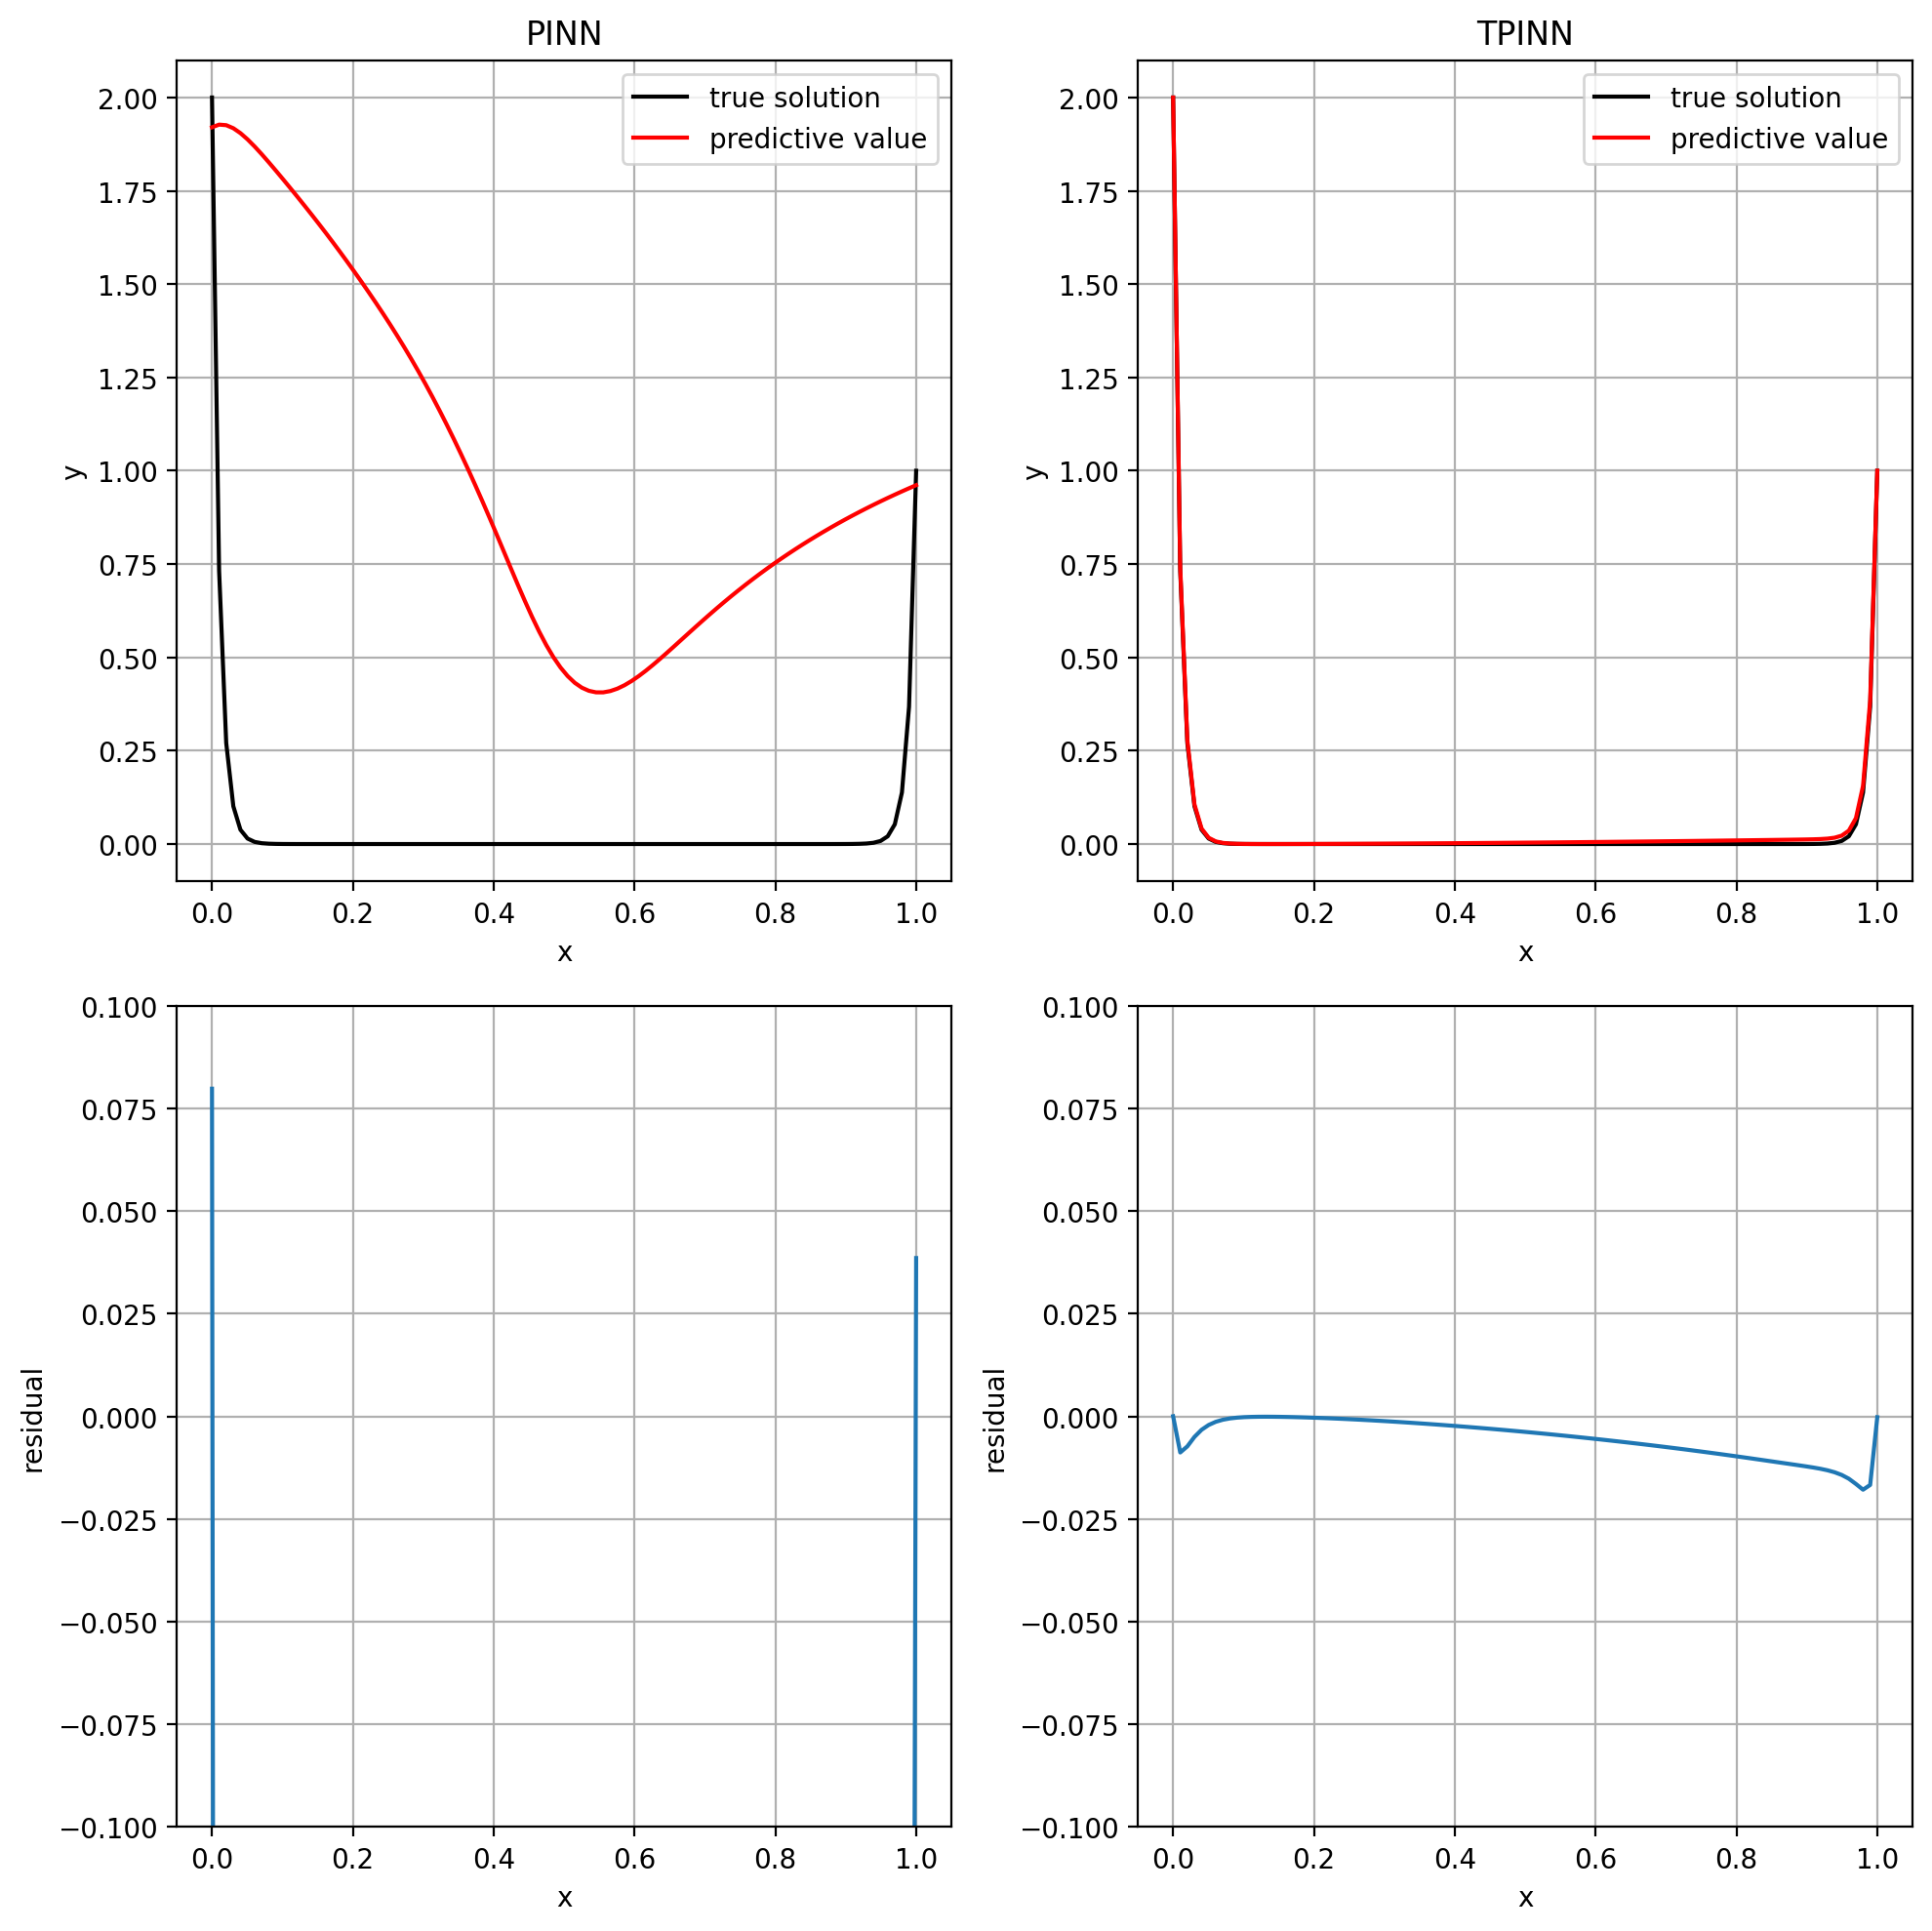

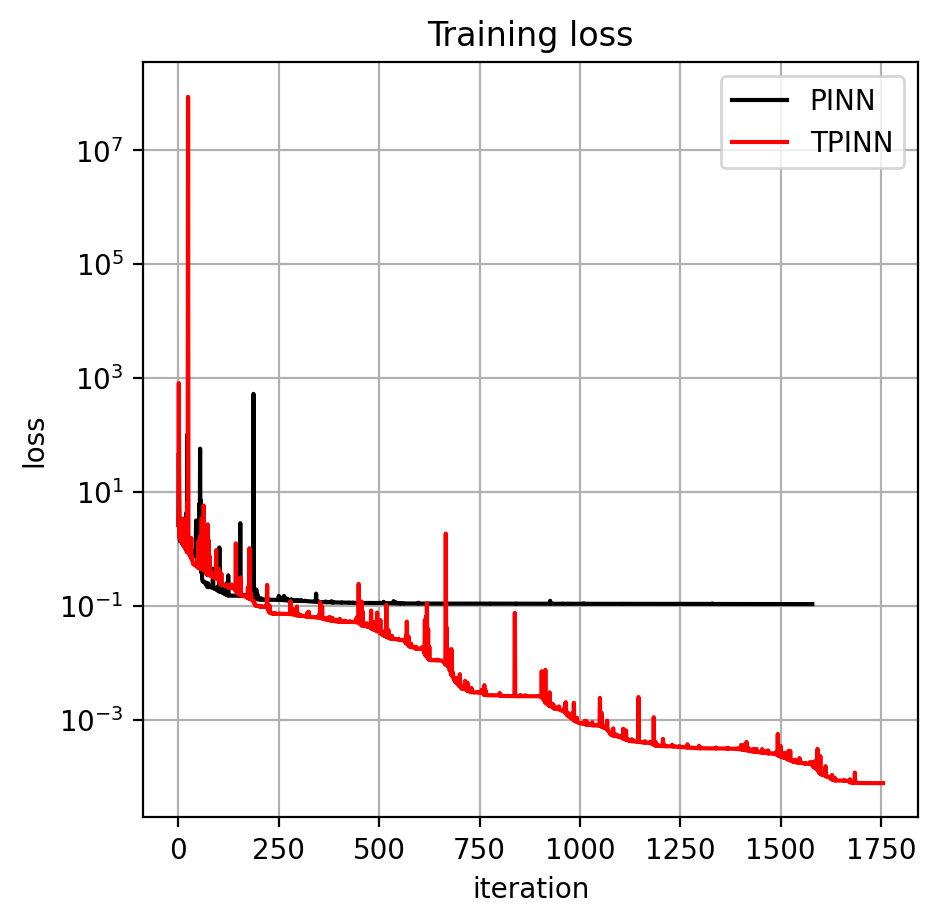

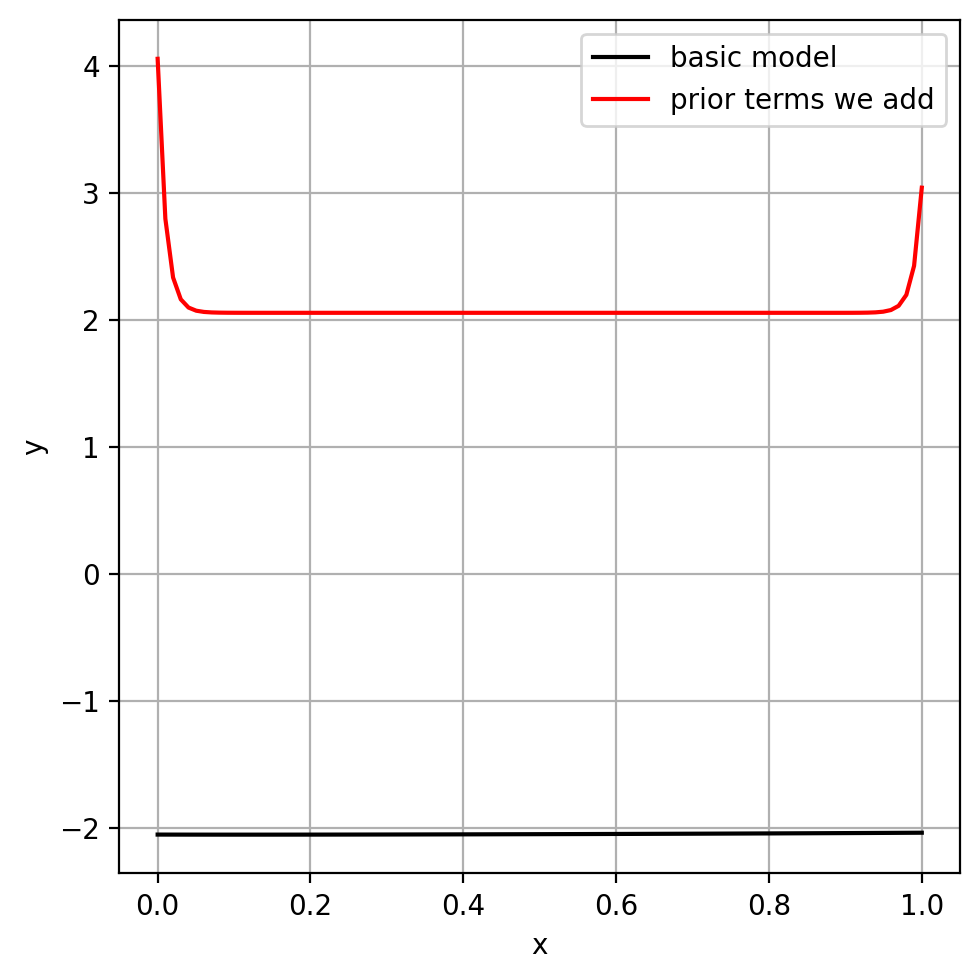

In [8]:
print('epsilon =',e)
print('c1,c2 =',c1_pred,c2_pred)

plt.figure(figsize=(10,10),dpi=200)
plt.subplot(2,2,1)
plt.title('PINN')
plt.plot(x,y,color='k',label='true solution')
plt.plot(x,pinn_pred,color='r',label='predictive value')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.subplot(2,2,2)
plt.title('TPINN')
plt.plot(x,y,color='k',label='true solution')
plt.plot(x,pred,color='r',label='predictive value')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.subplot(2,2,3)
plt.plot(x,res_pinn)
plt.ylim((-0.1,0.1))
plt.xlabel('x')
plt.ylabel('residual')
plt.grid()
plt.subplot(2,2,4)
plt.plot(x,res)
plt.ylim((-0.1,0.1))
plt.xlabel('x')
plt.ylabel('residual')
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5),dpi=200)
plt.title('Training loss')
plt.plot(pinn.history,color='k',label='PINN')
plt.plot(newpinn.history,color='r',label='TPINN')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale('log')
plt.grid()
plt.show()

plt.figure(figsize=(5,5),dpi=200)
plt.plot(x,model.predict(x),c='k',label='basic model')
plt.plot(x,c1_pred*tf.exp(index_1.predict((x-1)/e)) + c2_pred*tf.exp(index_2.predict(-x/e)),c='r',label='prior terms we add')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()